In [1]:
import pandas as pd
import matplotlib.pyplot as plt
X_train = pd.read_csv("./UCI HAR Dataset/train/X_train.txt", sep=",", names=[i for i in range(0,561)]).to_numpy()
X_test = pd.read_csv("./UCI HAR Dataset/test/X_test.txt", sep=",", names=[i for i in range(0,561)]).to_numpy()
y_train = pd.read_csv("./UCI HAR Dataset/train/y_train.txt", names=["Y"]).to_numpy()
y_test = pd.read_csv("./UCI HAR Dataset/test/y_test.txt", names=["Y"]).to_numpy()

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Класс, который в последствии добавляется в словарь для удобного выбора
class Node:
    def __init__(
        self,
        feature=None,
        threshold=None,
        # childs=None,
        left = None,
        right = None,
        value=None,
        proba_value = None
    ):
        self.feature = feature
        self.threshold = threshold
        # self.childs = childs
        self.value = value
        self.right = right
        self.left = left
        self.proba_value = proba_value

    def is_leaf_node(self):
        return self.value is not None
    


class DecisionTree_BOOOOSTED:
    def __init__(self, max_depth=10, min_samples=10):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None
        self.classes = None


    def fit(self, X, y):
        self.classes = np.unique(y)
        self.tree = self.grow_tree(X, y)


    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])


    def mse(self, y:np.ndarray):
        return np.mean((np.mean(y)-y)**2)
    
    def mean(self, y):
        return np.mean(y)

    def information_gain(self, X_column: list, y: list, threshold:float):

        n = y.shape[0]


        left_inds = np.argwhere(X_column <= threshold).flatten()
        right_inds = np.argwhere(X_column > threshold).flatten()


        mse_split = 0
        if left_inds.shape[0]!=0:
            mse_left = self.mse(y[left_inds])
            mse_split += (left_inds.shape[0]  / n) * mse_left
        if right_inds.shape[0]!=0:
            mse_right = self.mse(y[right_inds])
            mse_split += (right_inds.shape[0] / n) * mse_right
        return mse_split, threshold


    def best_split(self, X, y):
        best_feature, best_threshold = None, None
        # best_gain = -1
        best_gini = np.inf
        # uitems = []
        for i in range(X.shape[1]):
            #==============================================
            tresholds = np.random.choice(np.unique(X[:, i]), 10)
            # print("hehe")
            # tresholds = np.unique(X[:, i])
            # print("new_i")
            for trashold in tresholds:
            #==============================================
                gini, threshold = self.information_gain(X[:, i], y, trashold)
                if gini < best_gini:
                    # print(gini)
                    best_gini = gini
                    best_feature = i
                    # print(threshold)
                    best_threshold = threshold

        return best_feature, best_threshold

    def grow_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        n_labels = np.unique(y).shape[0]

        if n_samples <= self.min_samples or depth >= self.max_depth or n_labels <= 1:
            return Node(value=self.mean(y))

        #==============================================
        best_feature, best_threshold = self.best_split(X, y)
        l_inds = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        r_inds = np.argwhere(X[:, best_feature] > best_threshold).flatten()

        # print(l_inds)
        # print(r_inds) 
        if l_inds.shape[0] == 0 or r_inds.shape[0] == 0:
            return Node(value=self.mean(y))
        
        

        left = self.grow_tree(X = X[l_inds], y = y[l_inds], depth = depth+1)
        right = self.grow_tree(X = X[r_inds], y = y[r_inds], depth = depth+1)

        return Node(best_feature, best_threshold, left, right)


    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.value
        
        return self.travers_tree(x, tree.left) if tree.threshold >= x[tree.feature] else self.travers_tree(x, tree.right)


In [6]:
class GradientBoosting:
    def __init__(self, learning_rate=0.2, n_estimators=100, max_depth=3):
        """
        :param learning_rate: скорость обучения
        :param n_estimators: количество деревьев
        :param max_depth: максимальная глубина деревьев
        """
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.num_classes = None
        self.base_estimators = []
        
    def sigmoid(self, y_pred):
        """
        :param y_pred: прогноз модели
        :return: значение функции сигмоиды для прогноза
        """
        return 1.0 / (1.0 + np.exp(-y_pred))
    
    def softmax(self, y_pred):
        """
        :param y_pred: прогноз модели
        :return: значение функции softmax для прогноза
        """
        exp_pred = np.exp(y_pred)
        return exp_pred / np.sum(exp_pred, axis=1)[:, np.newaxis]


    def logloss_gradient(self, y_true, y_pred):
        """
        :param y_true: истинный ответ
        :param y_pred: прогноз модели
        :return: значение градиента функции потерь logLoss
        """
        p = y_pred #self.softmax_test(y_pred)
        return (p - y_true) / y_true.shape[0]
    
    def fit(self, X, y):
        """
        Обучение градиентного бустинга с OneVsAll методом.
        :param X: матрица объектов (numpy array)
        :param y: вектор истинных ответов (numpy array)
        """
        self.num_classes = np.unique(y).shape[0]

        for k in range(self.num_classes):
            y_k = np.where(y == k, 1., 0.)
            self.base_estimators.append([])
            y_pred = np.zeros_like(y_k, dtype=np.float64)
            # print(y_pred)
            estimator = DecisionTree_BOOOOSTED(max_depth=self.max_depth)
            estimator.fit(X, y_k)
            # y_pred += estimator.predict(X)
            self.base_estimators[-1].append(estimator)
            y_pred += estimator.predict(X)
            # print(y_pred)
            m=0
            while m < self.n_estimators:
                m+=1
                anti_grad = -self.logloss_gradient(y_k, y_pred)
                estimator = DecisionTree_BOOOOSTED(max_depth=self.max_depth)
                # Идём в сторону АНТИГРАДИЕНТА БЛИН, АН-ТИ ГРАДИЕНТА (-2 часа в попытках найти баг в дереве)
                estimator.fit(X, anti_grad)
                otv =estimator.predict(X)

                y_pred += otv * self.learning_rate
                if np.unique(anti_grad).shape[0]==1:
                    m = self.n_estimators + 1

                self.base_estimators[-1].append(estimator)
                
                
    def predict_proba(self, X):
        """
        Предсказание вероятности класса.
        """
        y_pred_proba = np.zeros((X.shape[0], self.num_classes))

        # print(y_pred_proba)
        # А нужен ли этот for?
        # for m in range(self.n_estimators):
        
        for k, estimators in enumerate(self.base_estimators):
            flag = 1
            for estimator in estimators:
                y_pred_proba[:, k] += flag * estimator.predict(X)

                flag = self.learning_rate
            

        return self.softmax(y_pred_proba / np.linalg.norm(y_pred_proba, axis=1, keepdims=True))
    
    def pred_proba_auc_roc(self, X, class_ind):

        flag = 1
        y_pred_proba = np.zeros(X.shape[0])
        
        flag = 1
        for estimator in self.base_estimators[class_ind]:
            y_pred_proba += flag * estimator.predict(X)

            flag = self.learning_rate

        return y_pred_proba

    def predict(self, X):
        """
        Предсказание класса.
        """
        y_pred_proba = self.predict_proba(X)
        return np.argmax(y_pred_proba, axis=1)

In [7]:
clf = GradientBoosting(max_depth=4, n_estimators=10)
cols = np.array([1,2,3, 41, 42, 43, 81, 82, 83, 121, 122, 123, 161, 162, 163, 201,202,203, 241, 242, 243, 281,282,283, 321,322,323, 361,362,363, 401,402,403]) - 1

clf.fit(X_train[:,cols], y_train.flatten() -1)
otv = clf.predict(X_test[:,cols])

In [8]:
def AUC_ROC(y_true, y_pred_proba, class_ind=1):
    # y_true1, y_pred_proba_1 = list(zip(*list(sorted(zip(y_true, y_pred_proba), key = lambda x : x[1]))))
    sorted_indices = np.argsort(y_pred_proba)[::-1]
    sorted_y_true = y_true[sorted_indices]
    sorted_y_pred = y_pred_proba[sorted_indices]
    print(sorted_y_pred)
    print(sorted_y_true)
    otv_list_y = []
    otv_list_x = []
    flag_y = 0
    flag_x = 0
    for y in sorted_y_true:
        if y == 1:
            flag_y+=1
        else:
            flag_x += 1
        otv_list_y.append(flag_y)
        otv_list_x.append(flag_x)

    otv_list_x = np.array(otv_list_x)
    otv_list_y = np.array(otv_list_y)
    plt.plot(otv_list_x/otv_list_x[-1], otv_list_y/otv_list_y[-1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'AUC - ROC Curve for class: {class_ind}')
    plt.show()


def AUC_ROC_one_vs_all(clf, y_true, X_test):
    for i in np.sort(np.unique(y_true)):
        print(i)
        AUC_ROC(np.where((y_true) == i, 1, 0), clf.pred_proba_auc_roc(X_test, i), class_ind=i)

0
[ 1.00002804e+00  1.00001915e+00  1.00001395e+00 ... -5.44000132e-05
 -5.58719027e-05 -7.25888290e-05]
[1 1 1 ... 0 0 0]


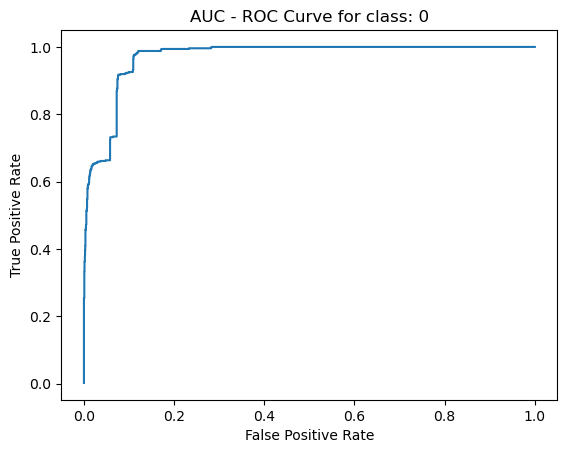

1
[ 9.86064468e-01  9.86062396e-01  9.86059407e-01 ... -3.45385777e-06
 -4.46568176e-06 -1.10848054e-05]
[1 1 1 ... 0 0 0]


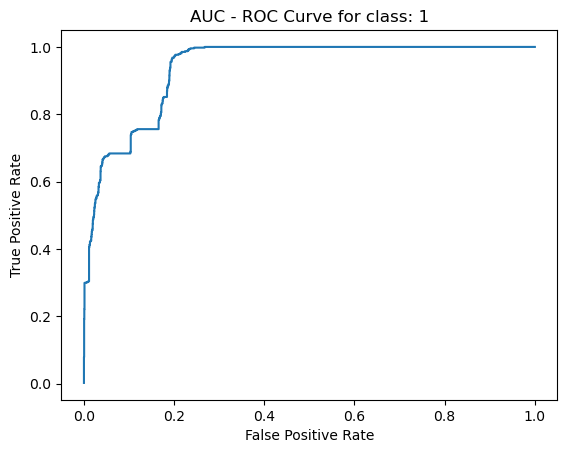

2
[ 1.00001683e+00  1.00001626e+00  1.00001626e+00 ... -2.97203077e-06
 -4.55632334e-06 -7.43093125e-06]
[1 1 1 ... 0 0 0]


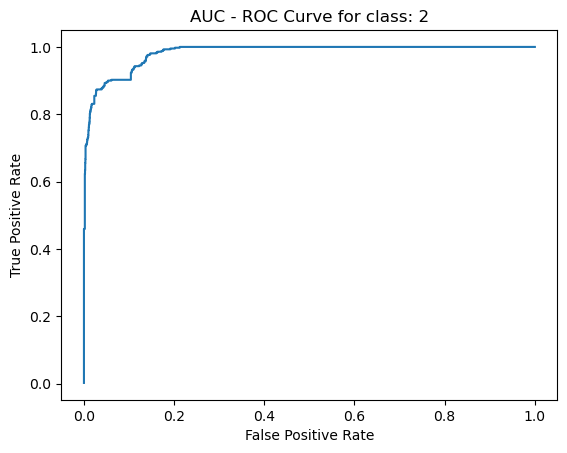

3
[ 7.82196260e-01  7.82196260e-01  7.82196260e-01 ... -1.30901139e-04
 -1.30901139e-04 -1.30901139e-04]
[1 1 1 ... 0 0 0]


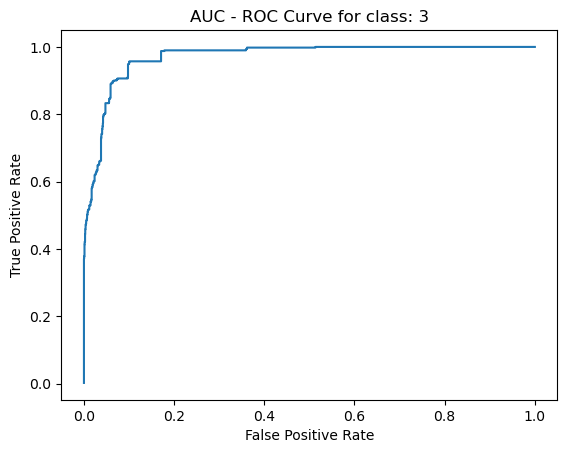

4
[ 9.39079285e-01  9.39079285e-01  9.39079285e-01 ... -3.62655717e-05
 -3.73495708e-05 -4.03607658e-05]
[0 0 0 ... 0 0 0]


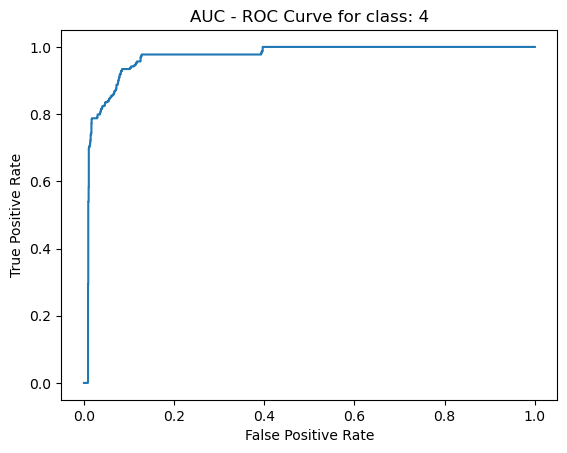

5
[ 1.00000906e+00  1.00000000e+00  1.00000000e+00 ... -1.54592818e-06
 -2.01331383e-06 -5.03591378e-06]
[1 1 1 ... 0 0 0]


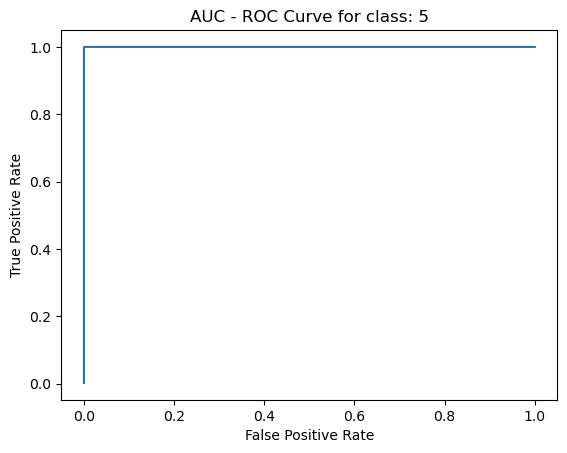

In [9]:
AUC_ROC_one_vs_all(clf, y_test.flatten()-1, X_test[:, cols])

In [10]:
def pre_rec_f1(y_true, y_pred):
    precision_list = []
    recall_list = []
    f1_list = []
    for i in np.unique(y_true):
        tp = np.sum((y_pred == i) * (y_true == i))
        fp = np.sum((y_pred==i) * (y_true != i))
        fn = np.sum((y_pred!=i) * (y_true == i))
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 = 2*precision*recall/(precision+recall)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"For {i} class {precision=}")
        print(f"For {i} class {recall=}")
        print(f"For {i} class {f1=}")
    
    print(f"Macro precision = {sum(precision_list)/len(precision_list)}")
    print(f"Macro recall = {sum(recall_list)/len(recall_list)}")
    print(f"Macro f1 = {sum(f1_list)/len(f1_list)}")
    print(f"accuracy = {np.sum(y_pred==y_true)/y_true.shape[0]}")

pre_rec_f1(y_test.flatten() - 1, otv)

For 0 class precision=0.7170818505338078
For 0 class recall=0.8125
For 0 class f1=0.7618147448015123
For 1 class precision=0.7453416149068323
For 1 class recall=0.7643312101910829
For 1 class f1=0.7547169811320755
For 2 class precision=0.9017341040462428
For 2 class recall=0.7428571428571429
For 2 class f1=0.8146214099216711
For 3 class precision=0.7725563909774437
For 3 class recall=0.8370672097759674
For 3 class f1=0.8035190615835778
For 4 class precision=0.839835728952772
For 4 class recall=0.768796992481203
For 4 class f1=0.802747791952895
For 5 class precision=1.0
For 5 class recall=1.0
For 5 class f1=1.0
Macro precision = 0.8294249482361832
Macro recall = 0.8209254258842327
Macro f1 = 0.8229033315652886
accuracy = 0.825246012894469
